## GAN with MNIST dataset

In [ ]:
# 필요 라이브러리 호출
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 파라미터를 먼저 설정해보죠
noise_size = 100
batch = 100
learning_rate = 2e-04
epoch = 100

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# GAN은 Train, Test의 의미가 없어요!
train_dataset = datasets.MNIST('./mnist_data',
                              download=True,
                              train=True,
                              transform=transforms.ToTensor(),
                              )

In [ ]:
# 데이터셋 로더 호출
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch,shuffle=True,drop_last=False)

In [ ]:
# 잡음생성함수
def gen_z(batch_size,noise_size):
  return np.random.normal(size=(batch_size,noise_size))

## Discriminator and Generator model

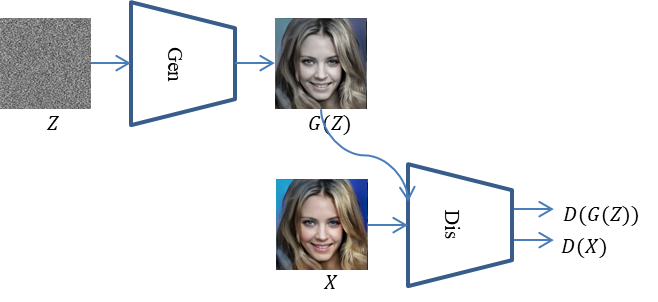

In [ ]:
# Dicirminator model
'''
784 -> 1024 -> 512 -> 256 -> 1
https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN 참조
'''
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.sequence = nn.Sequential(
        nn.Linear(784,1024),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024,512),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Linear(512,256),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Linear(256,1),
        nn.Sigmoid()
    )

  def forward(self,x):
    # last output은 sigmoid로 확률분포로 만들어야 함!
    x = self.sequence(x)
    return x

In [ ]:
# Generator model  
'''
100 -> 256 -> 512 -> 1024 -> 784
'''
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.sequence = nn.Sequential(
        nn.Linear(100,256),
        nn.LeakyReLU(),
        nn.Linear(256,512),
        nn.LeakyReLU(),
        nn.Linear(512,1024),
        nn.LeakyReLU(),
        nn.Linear(1024,784),
        nn.Tanh()
    )

  def forward(self,z):
    z = self.sequence(z)
    return z

## GAN loss function setting

분류기 손실함수 --> 생성모델 확률감소 + 원 이미지 확률 상승

$L_d = -{{1}\over{m}}\sum{(log(D(X))+log(1-D(G(z)))}$






생성자 손실함수 --> 생성모델 확률상승

$L_g = {{1}\over{m}}\sum{log(1-D(G(z)))}$

In [ ]:
def Discriminator_loss(D_x,D_gz):
  '''
  D_x : 원래 이미지 확률
  D_gz: 생성 이미지 확률
  '''
  return -torch.mean(torch.log(D_x+1e-15)+torch.log(1-D_gz+1e-15))

def Generator_loss(D_gz):
  '''
  D_gz: 생성이미지 확률
  '''
  #return torch.mean(torch.log(1-D_gz))
  return -torch.mean(torch.log(D_gz+1e-15))

In [ ]:
d_model = Discriminator().to(device)
g_model = Generator().to(device)

# 코딩단계에선 Generator모델을 학습시켜야 합니다!
optimizerD = optim.Adam(d_model.parameters(),lr=learning_rate)
optimizerG = optim.Adam(g_model.parameters(),lr=learning_rate)

In [ ]:
#학습 시작
D_loss, G_loss = [],[]
for ep in range(epoch):
  d_, g_ = 0, 0,
  for X,_ in train_loader:
    X = X.view(-1,784)
    X = (X-0.5)/0.5

    # Discriminator 학습
    d_model.zero_grad()
    X = X.to(device)
    Z = gen_z(X.shape[0],noise_size)
    Z = torch.Tensor(Z).to(device)

    gz = g_model(Z)
    D_gz = d_model(gz)
    D_x = d_model(X)

    loss_d = Discriminator_loss(D_x,D_gz)
    loss = loss_d
    d_ += loss.item()

    optimizerD.zero_grad()
    loss.backward()
    optimizerD.step()
    
    # Generator 학습
    g_model.zero_grad()
    gz = g_model(Z)
    D_gz = d_model(gz)
    loss_g = Generator_loss(D_gz)
    loss = loss_g
    g_ += loss.item()
    optimizerG.zero_grad()
    loss.backward()
    optimizerG.step()

  if ep % 5 == 0:
    print('Epoch {}, Discriminator loss {}, Generator loss {}'.format(ep,d_/len(train_loader),g_/len(train_loader)))

In [ ]:
# Generator 평가
Z = gen_z(10,noise_size)
Z = torch.Tensor(Z).to(device)

gz = g_model(Z).detach().cpu().numpy()
gz = np.reshape(gz,(-1,28,28))

fig = plt.figure(figsize=(12,12))
columns = 10
rows = 1

for idx,img in enumerate(gz):
  fig.add_subplot(rows,columns,idx+1)
  plt.imshow(img[:,:]*255)